In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import permutation_test, false_discovery_control, spearmanr
import pybedtools

from warnings import filterwarnings
filterwarnings("ignore", category=pd.errors.DtypeWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#set up paths
#=========================
workdir = '/home/AD/rkgadde/L1IP'
annotation = f'{workdir}/hg38_data/annotations/gencode.v46.basic.annotation.sorted.genes.gff3'
celltypes = f'{workdir}/celltypes.txt'

genedir = f'{workdir}/gene_data'
figdir = f'{workdir}/results/CZI/plots'

# Load in data

In [10]:
#process l1
me_type = 'L1'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'
abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
abs_df['me_type'] = 'absence'
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6, 7,8],  names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
ins_df['me_type'] = 'insertion'
l1_df = pd.concat([abs_df, ins_df])
l1_df['class'] = 'l1'

#process alu
me_type = 'Alu'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'
abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
abs_df['me_type'] = 'absence'
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6, 7,8],  names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
ins_df['me_type'] = 'insertion'
alu_df = pd.concat([abs_df, ins_df])
alu_df['class'] = 'alu'

#combine + add labels
#===============================
comb_df = pd.concat([l1_df, alu_df])
comb_df['start'] = comb_df['start'].astype(int)
comb_df['end'] = comb_df['end'].astype(int)
comb_df['length'] = comb_df['end'] - comb_df['start']
comb_df['het'] = comb_df['het'].fillna('NaN').astype(str)
comb_df['hom'] = comb_df['hom'].fillna('NaN').astype(str)
comb_df.reset_index(drop=True, inplace=True)
het_bool = np.asarray([True if 'NaN' not in i else False for i in comb_df['het']])
hom_bool = np.asarray([True if 'NaN' not in i else False for i in comb_df['hom']])
het_count = np.asarray([len(i.split(',')) for i in comb_df['het']])
hom_count = np.asarray([len(i.split(',')) for i in comb_df['hom']])
ratio = het_count/hom_count
#set to NaN and inf
ratio[(het_bool == False) & (hom_bool==False)] = np.nan
ratio[(het_bool == True) & (hom_bool==False)] = np.inf
ratio[(het_bool == False) & (hom_bool==True)] = -1*np.inf
comb_df['het_over_hom'] = ratio
# label as majority het or hom, if >2x
genotype = np.empty(len(comb_df)).astype(str)
genotype[ratio > 2] = 'het'
genotype[ratio < 0.5] = 'hom'
genotype[(ratio < 2) & (ratio > 0.5)] = 'mixed'
genotype[np.isnan(ratio)] = 'NaN'
comb_df['genotype'] = genotype
#label as truncated or full length
trunc = np.empty(len(comb_df), dtype=object)
l1_mask = comb_df['class'] == 'l1'
trunc[l1_mask & (comb_df['length'] > 5500)] = 'full_length'
trunc[l1_mask & (comb_df['length'] <= 5500)] = 'truncated'
alu_mask = comb_df['class'] == 'alu'
trunc[alu_mask & (comb_df['length'] > 250)] = 'full_length'
trunc[alu_mask & (comb_df['length'] <= 250)] = 'truncated'
comb_df['insertion_category'] = trunc

#bedconvert and load annotations
l1_df = comb_df[comb_df['class']=='l1'].copy()
alu_df = comb_df[comb_df['class']=='alu'].copy()
alu_bt = pybedtools.BedTool.from_dataframe(alu_df)
l1_bt = pybedtools.BedTool.from_dataframe(l1_df)
cgi_df = pd.read_csv('/cndd3/dburrows/DATA/annotations/gencode/gencode.v37.CGI.hg38.jofan.bed', sep='\t',header=None)
all_df = pd.read_csv('/cndd3/dburrows/DATA/annotations/gencode/red.bed', sep='\t',header=None)
cgi_bt = pybedtools.BedTool.from_dataframe(cgi_df)
all_bt = pybedtools.BedTool.from_dataframe(all_df)

# plot basic statistics of MEs

In [601]:
#plot number of intersections by genotype, insertion type, length, region
#combine together intersected labelled data
#===========================================
curr = comb_df
#remove any that arent labelled as het or hom
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    if type(curr['het'][i]) != float:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if type(curr['hom'][i]) != float:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

comb_int_df = new_df

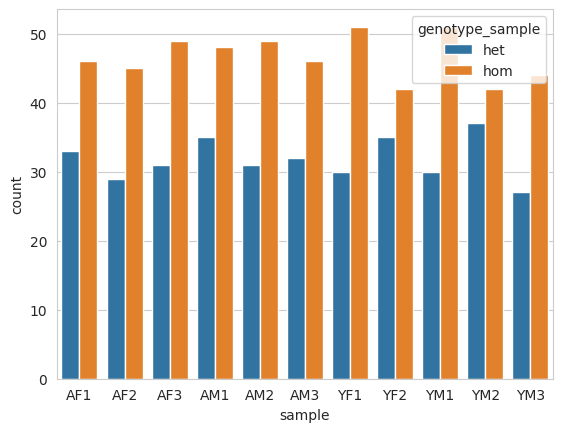

In [602]:
#plot 
#l1 absences
l1_samp_df = comb_int_df[comb_int_df['class']=='l1']
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='absence'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

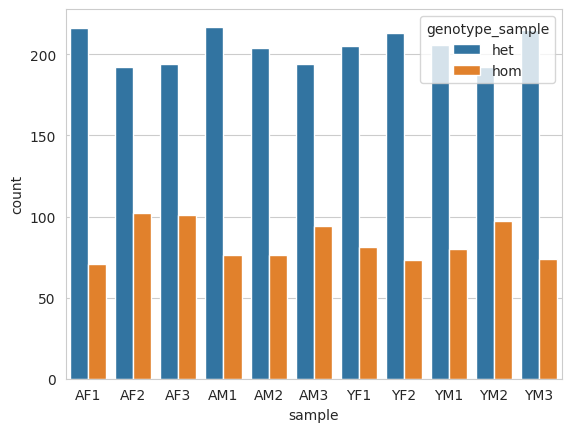

In [591]:
#plot l1
#l1 insertions
l1_samp_df = comb_int_df[comb_int_df['class']=='l1']
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='insertion'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

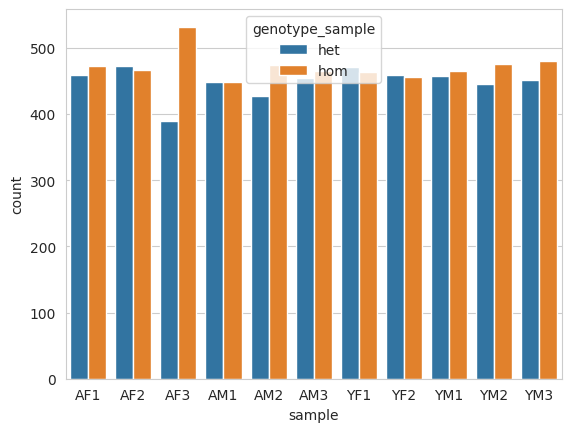

In [592]:
#plot alu
#alu absences
alu_samp_df = comb_int_df[comb_int_df['class']=='alu']
plot_df = pd.DataFrame(alu_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='absence'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

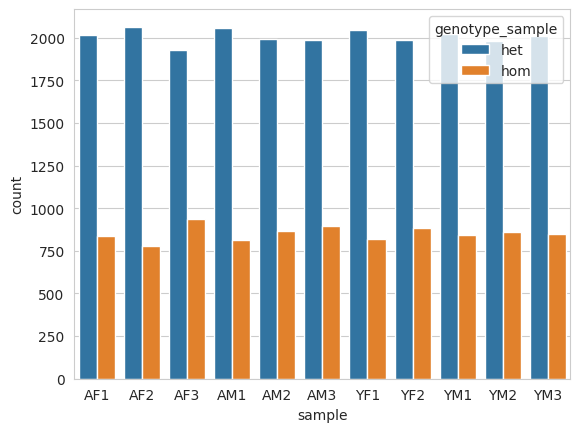

In [593]:
#plot alu
#alu insertions
alu_samp_df = comb_int_df[comb_int_df['class']=='alu']
plot_df = pd.DataFrame(alu_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='insertion'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

# Compute intersection

In [41]:
#compute intersection
l1_cgi = l1_bt.intersect(cgi_bt, f=0.3, wo=True) 
alu_cgi = alu_bt.intersect(cgi_bt, f=0.3, wo=True) 
alu_all = alu_bt.intersect(all_bt, f=0.3, wo=True) 
l1_all = all_bt.intersect(l1_bt, f=0.3, wo=True) 

l1_cgi_df = l1_cgi.to_dataframe(disable_auto_names=True, header=None)
l1_cgi_df.rename(columns={16: 'region', 9: 'me_type', 11: 'genotype', 12: 'insertion_category', 7: 'het', 8: 'hom', 4: 'length'}, inplace=True)
alu_cgi_df = alu_cgi.to_dataframe(disable_auto_names=True, header=None)
alu_cgi_df.rename(columns={16: 'region', 9: 'me_type', 11: 'genotype', 12: 'insertion_category', 7: 'het', 8: 'hom', 4: 'length'}, inplace=True)
alu_all_df = alu_all.to_dataframe(disable_auto_names=True, header=None)
alu_all_df.rename(columns={16: 'region', 9: 'me_type', 11: 'genotype', 12: 'insertion_category', 7: 'het', 8: 'hom', 4: 'length'}, inplace=True)
l1_all_df = l1_all.to_dataframe(disable_auto_names=True, header=None)
l1_all_df.rename(columns={3: 'region', 15: 'me_type', 17: 'genotype', 18: 'insertion_category', 13: 'het', 14: 'hom', 10: 'length'}, inplace=True)

In [321]:
#plot number of intersections by genotype, insertion type, length, region

#combine together intersected labelled data
#===========================================
l1_out = pd.concat([l1_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    l1_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])

alu_out = pd.concat([alu_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    alu_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
comb_df = pd.concat([l1_out, alu_out])

curr = comb_df.copy()
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    if curr['het'][i] != '.':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if curr['hom'][i] != '.':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

comb_int_df = new_df

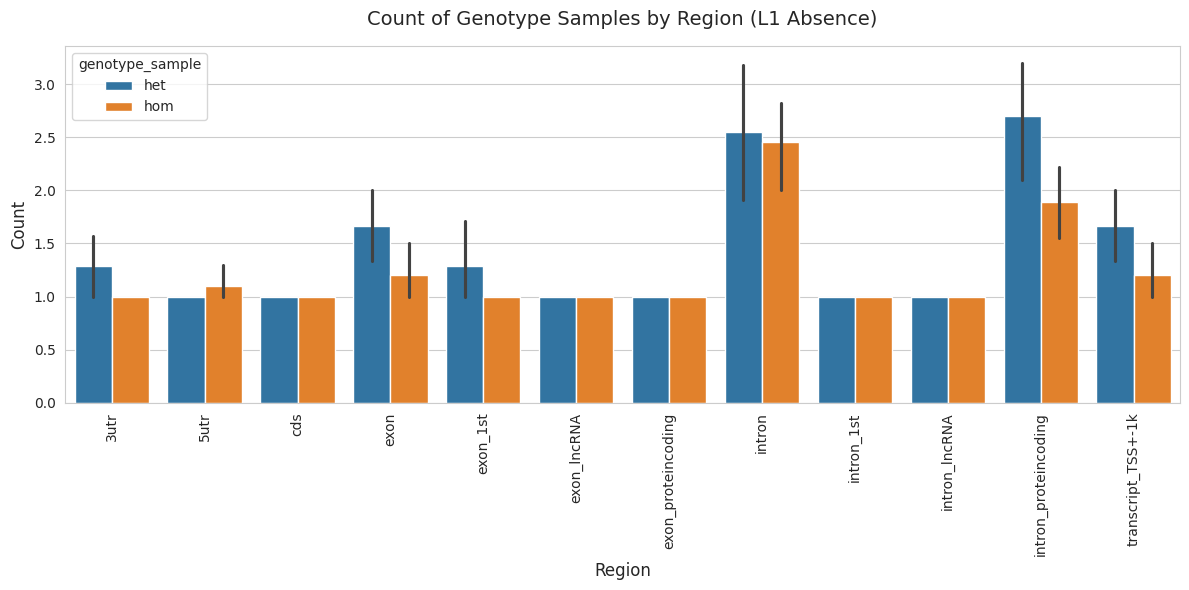

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'absence') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


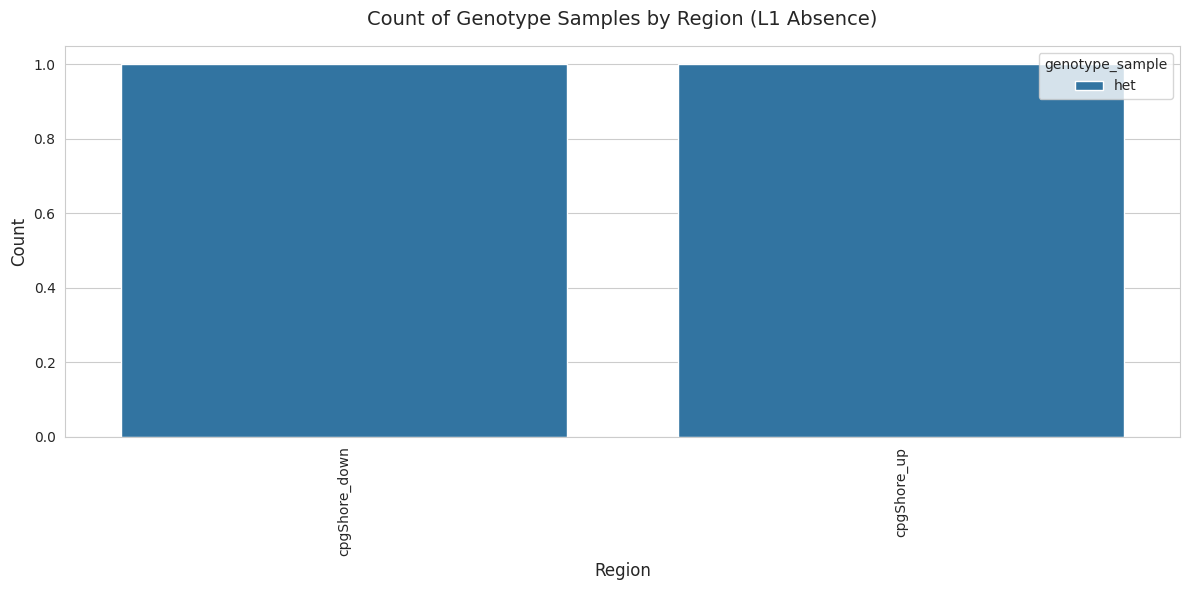

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'insertion') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


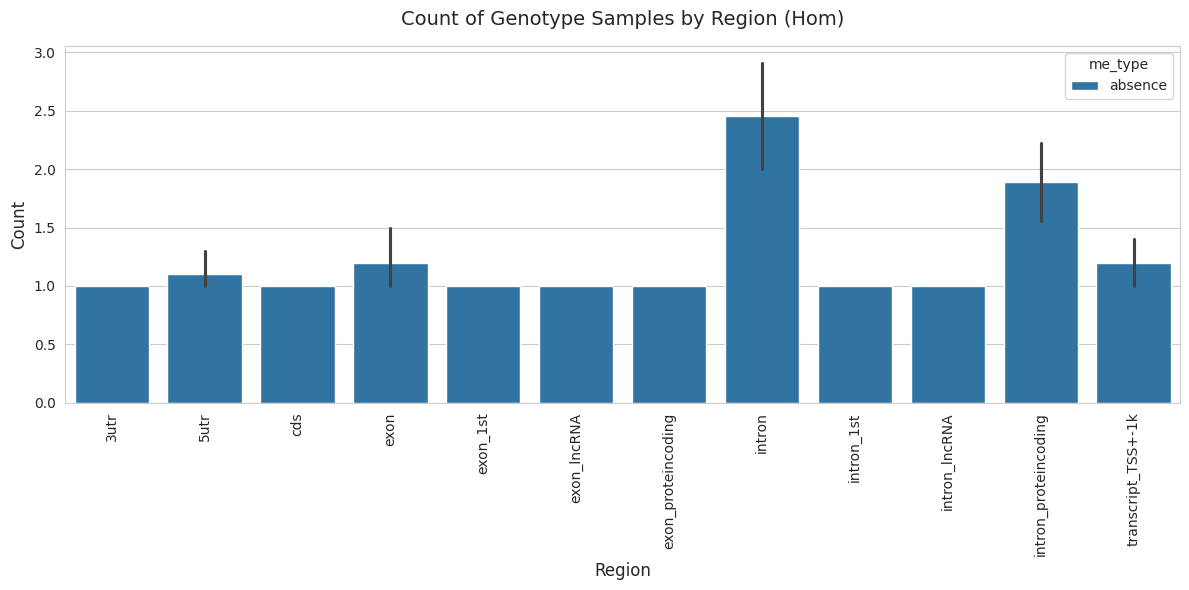

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'hom') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()

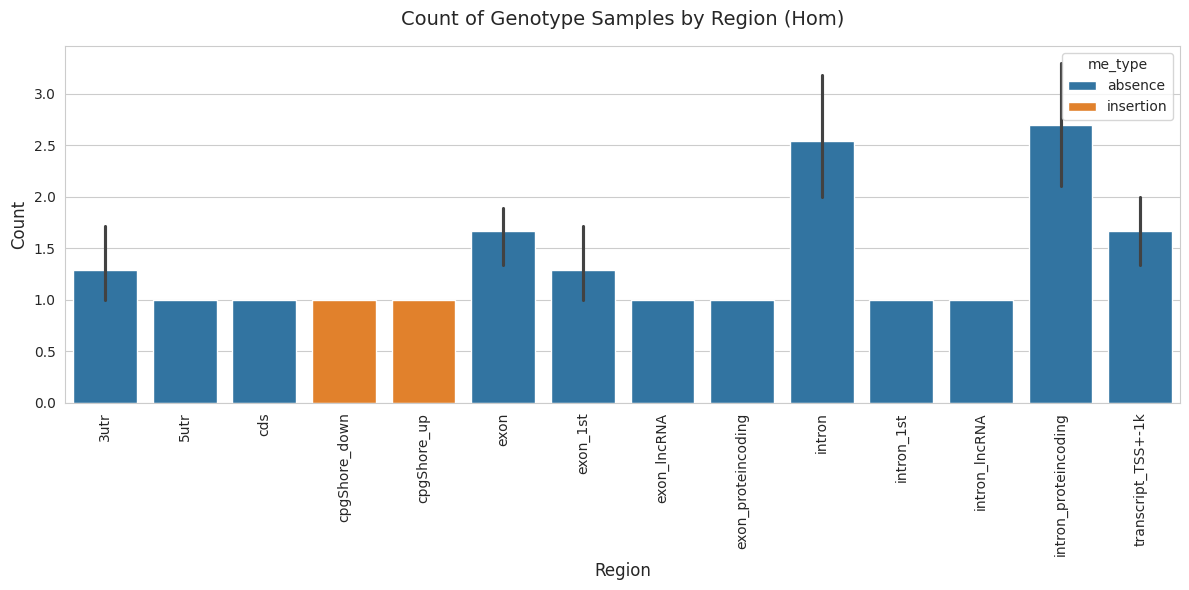

In [303]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'het') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


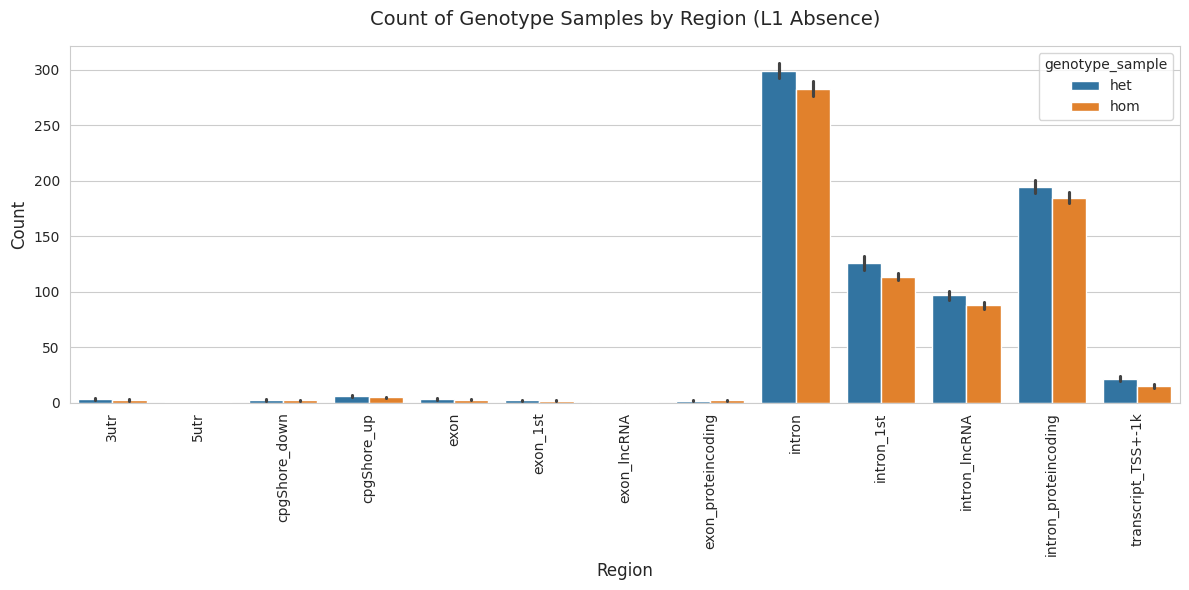

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'absence') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


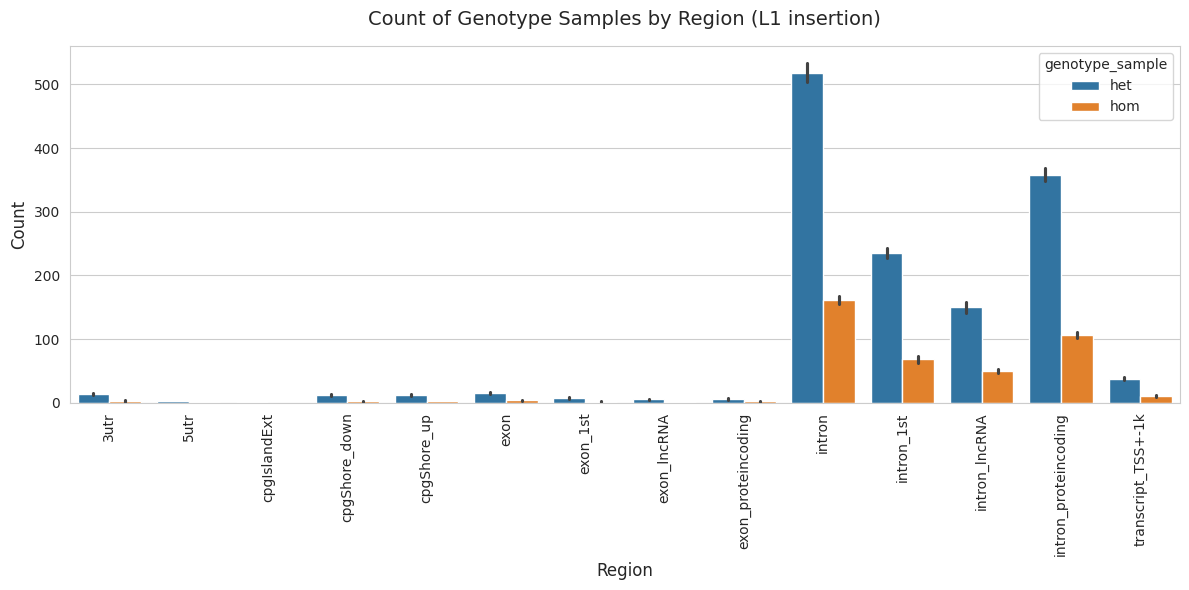

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'insertion') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 insertion)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


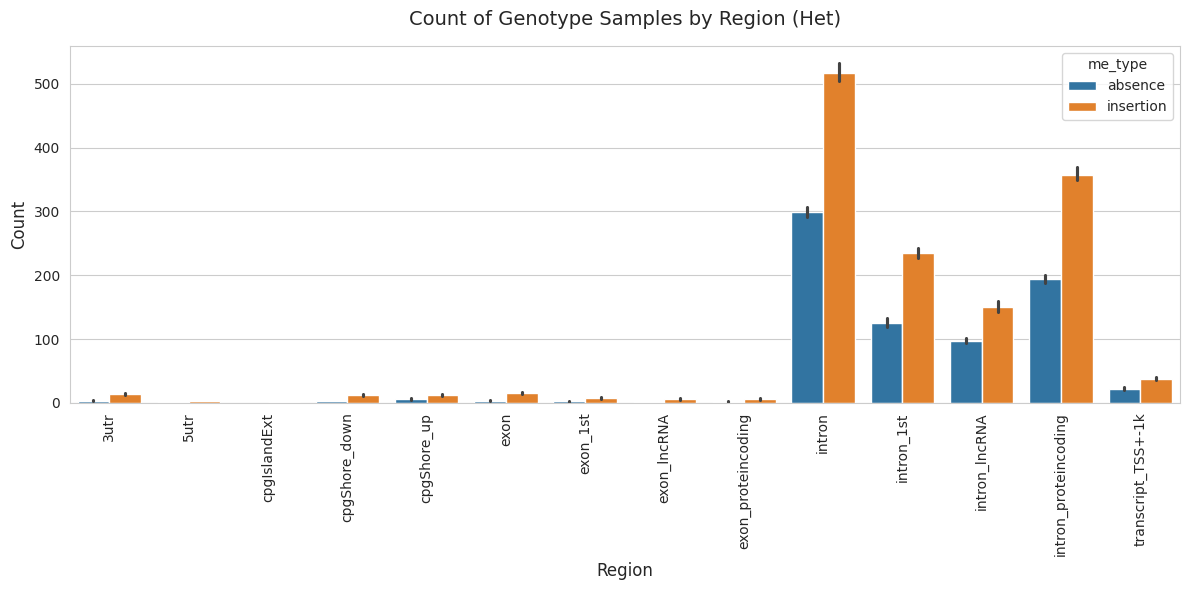

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'het') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Het)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


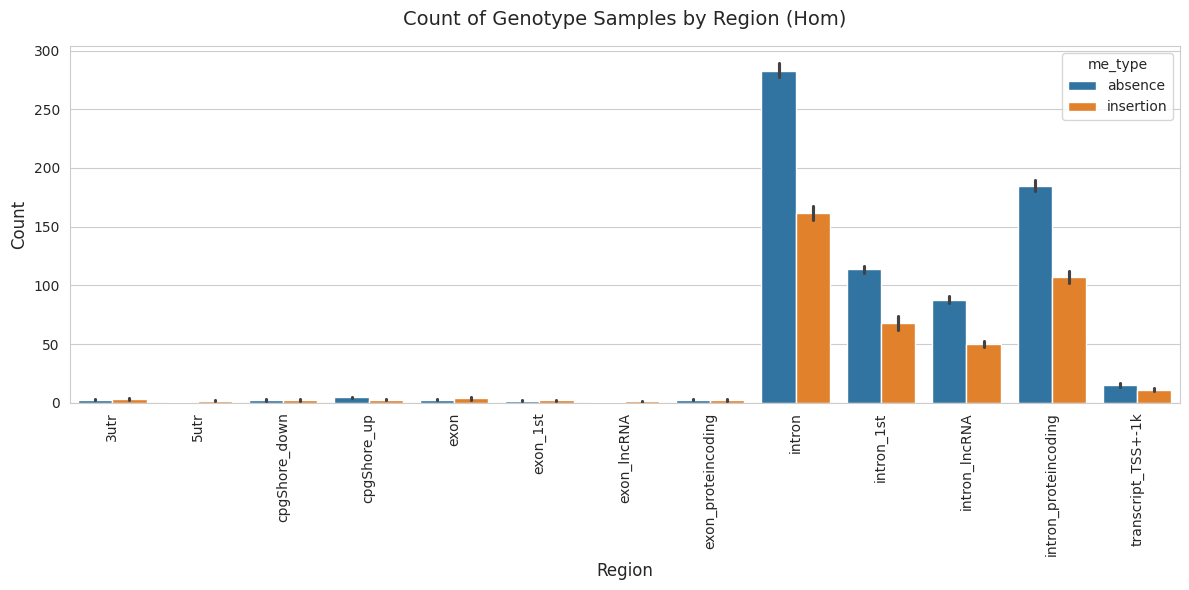

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'hom') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


# Enrichment analysis

In [59]:
#load in shuffled enrichment
tot_df = pd.read_csv('/cndd3/dburrows/DATA/me_polymorphisms/analysis/shuffle_enrichment.csv', sep = '\t', index_col=0)

#combine empirical data
l1_out = pd.concat([l1_cgi_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']], 
                    l1_all_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']]])
alu_out = pd.concat([alu_cgi_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']], 
                    alu_all_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
reg_names = np.append(all_df[3].unique(), cgi_df[3].unique())


In [53]:
tot_df['class'] == i

0       True
1       True
2       True
3       True
4       True
       ...  
475    False
476    False
477    False
478    False
479    False
Name: class, Length: 723900, dtype: bool

In [48]:
#combined
#===========
l1_ = pd.DataFrame(l1_out.groupby(['region']).count()['me_type'])
l1_ = l1_.reindex(reg_names, fill_value=0).reset_index()
l1_['class'] = 'l1'
alu_ = pd.DataFrame(alu_out.groupby(['region']).count()['me_type'])
alu_ = alu_.reindex(reg_names, fill_value=0).reset_index()
alu_['class'] = 'alu'
enr_df = pd.concat([l1_, alu_])
enr_df.rename(columns={'me_type':'count'}, inplace=True)


stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        observed_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)
        from scipy.stats import fisher_exact
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

/tmp/ipykernel_1012810/2923873454.py:33: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))


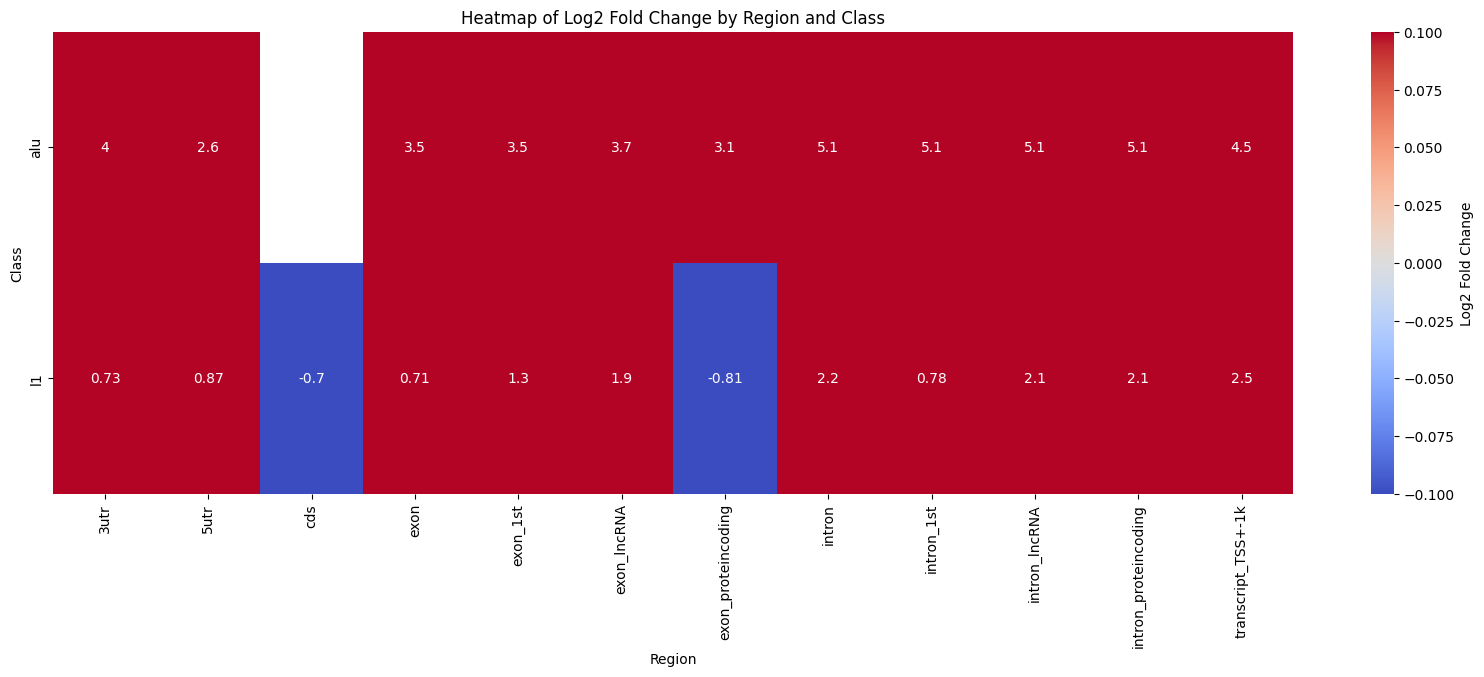

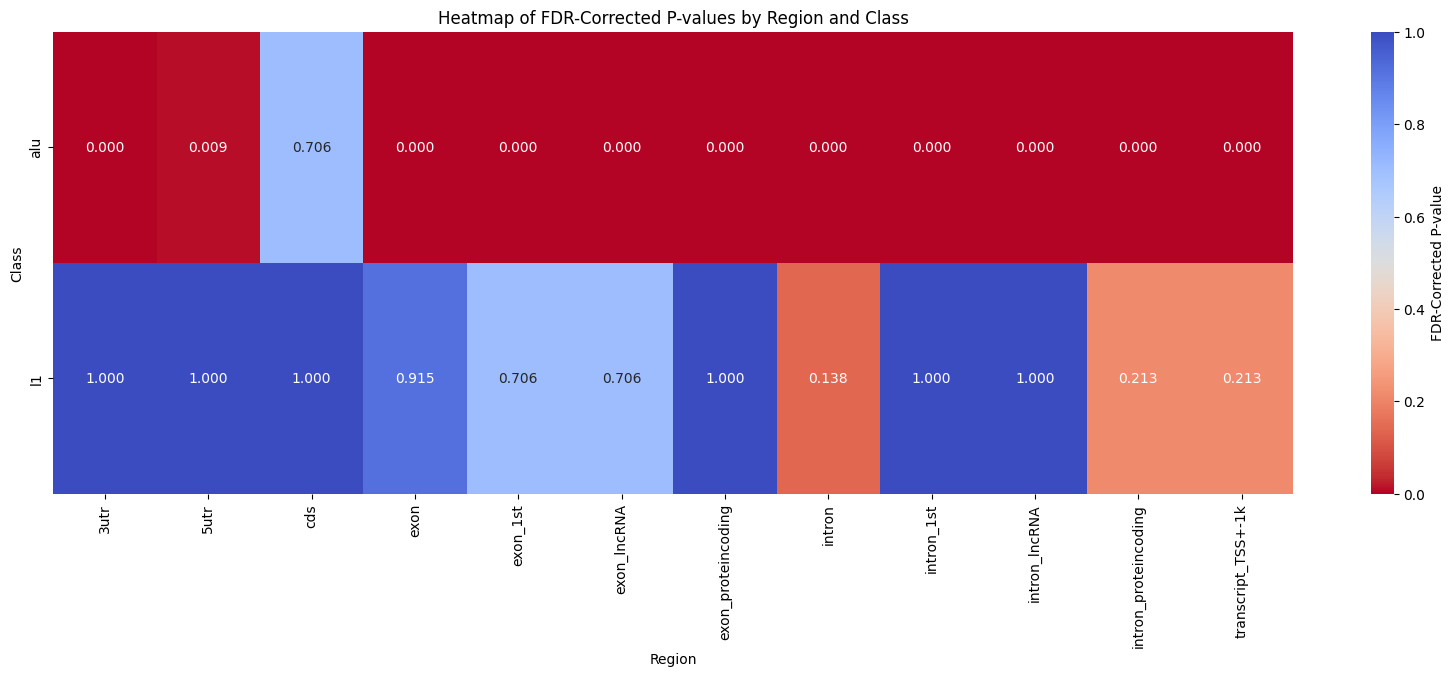

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')

# Plot Fold Change Heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_fc_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Log2 Fold Change'})
plt.title('Heatmap of Log2 Fold Change by Region and Class')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()

# Step 3: Pivot the DataFrame for FDR-Corrected P-Values Heatmap
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Plot FDR-Corrected P-Values Heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(
    heatmap_fdr_data,
    annot=True,
    fmt=".3f",  # Show FDR-corrected p-values with 3 decimal places
    cmap='coolwarm_r',
    cbar_kws={'label': 'FDR-Corrected P-value'}
)
plt.title('Heatmap of FDR-Corrected P-values by Region and Class')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()


In [443]:
#combined
#===========
#insertion + absence
l1_ = pd.DataFrame(l1_out[l1_out['me_type'] == 'insertion'].groupby(['region']).count()['hom'])
l2_ = pd.DataFrame(l1_out[l1_out['me_type'] == 'absence'].groupby(['region']).count()['hom'])
l1_ = pd.concat([l1_.reindex(reg_names, fill_value=0).reset_index(), l2_.reindex(reg_names, fill_value=0).reset_index()])
l1_['me_type'] = np.append( np.repeat('insertion', len(reg_names)), np.repeat('absence', len(reg_names))  )
l1_['class'] = 'l1'

alu_ = pd.DataFrame(alu_out[alu_out['me_type'] == 'insertion'].groupby(['region']).count()['hom'])
alu2_ = pd.DataFrame(alu_out[alu_out['me_type'] == 'absence'].groupby(['region']).count()['hom'])
alu_ = pd.concat([alu_.reindex(reg_names, fill_value=0).reset_index(), alu2_.reindex(reg_names, fill_value=0).reset_index()])
alu_['me_type'] = np.append( np.repeat('insertion', len(reg_names)), np.repeat('absence', len(reg_names))  )
alu_['class'] = 'alu'

enr_df = pd.concat([l1_, alu_])
enr_df.rename(columns={'hom':'count'}, inplace=True)

stat_region, stat_sig, stat_fc, stat_class, stat_type = [],[],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        for typ in ['insertion', 'absence']:
            observed_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i) & (enr_df['me_type'] == typ)]['count'].values[0]
            expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)
            from scipy.stats import fisher_exact
            no_overlap_observed = total_observed - observed_overlap
            no_overlap_expected = total_observed - expected_overlap
            # Contingency table
            contingency_table = [
                [observed_overlap, no_overlap_observed],  # Observed
                [expected_overlap, no_overlap_expected]  # Expected
            ]
            # Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
            stat_region.append(reg)
            stat_class.append(i + typ)
            stat_sig.append(p_value)
            stat_fc.append(np.log2(observed_overlap/expected_overlap))

/tmp/ipykernel_885107/2951987637.py:40: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_885107/2951987637.py:40: RuntimeWarning: invalid value encountered in scalar divide
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_885107/2951987637.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  stat_fc.append(np.log2(observed_overlap/expected_overlap))


In [445]:
# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
heatmap_fc_data

stat_region,3utr,5utr,cds,cpgIslandExt,cpgShore_down,cpgShore_up,exon,exon_1st,exon_lncRNA,exon_proteincoding,intron,intron_1st,intron_lncRNA,intron_proteincoding,transcript_TSS+-1k
stat_class,,,,,,,,,,,,,,,
aluabsence,-4.010019,-6.197354,-inf,-inf,-3.121550,-2.379066,-4.611179,-4.315595,-5.668233,-4.712563,-1.631791,-1.728069,-1.520141,-1.705731,-2.369210
aluinsertion,-1.255131,-2.496915,-inf,-4.027906,-0.969547,-0.893640,-1.736710,-1.730633,-1.346305,-2.127600,-0.466125,-0.452961,-0.502026,-0.454705,-1.063107
l1absence,-3.345325,-3.173687,-4.729825,NaN,NaN,NaN,-3.336105,-2.736497,-2.151696,-4.853197,-1.800212,-3.256256,-1.924100,-1.881012,-1.576401
l1insertion,-inf,-inf,-inf,NaN,inf,inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


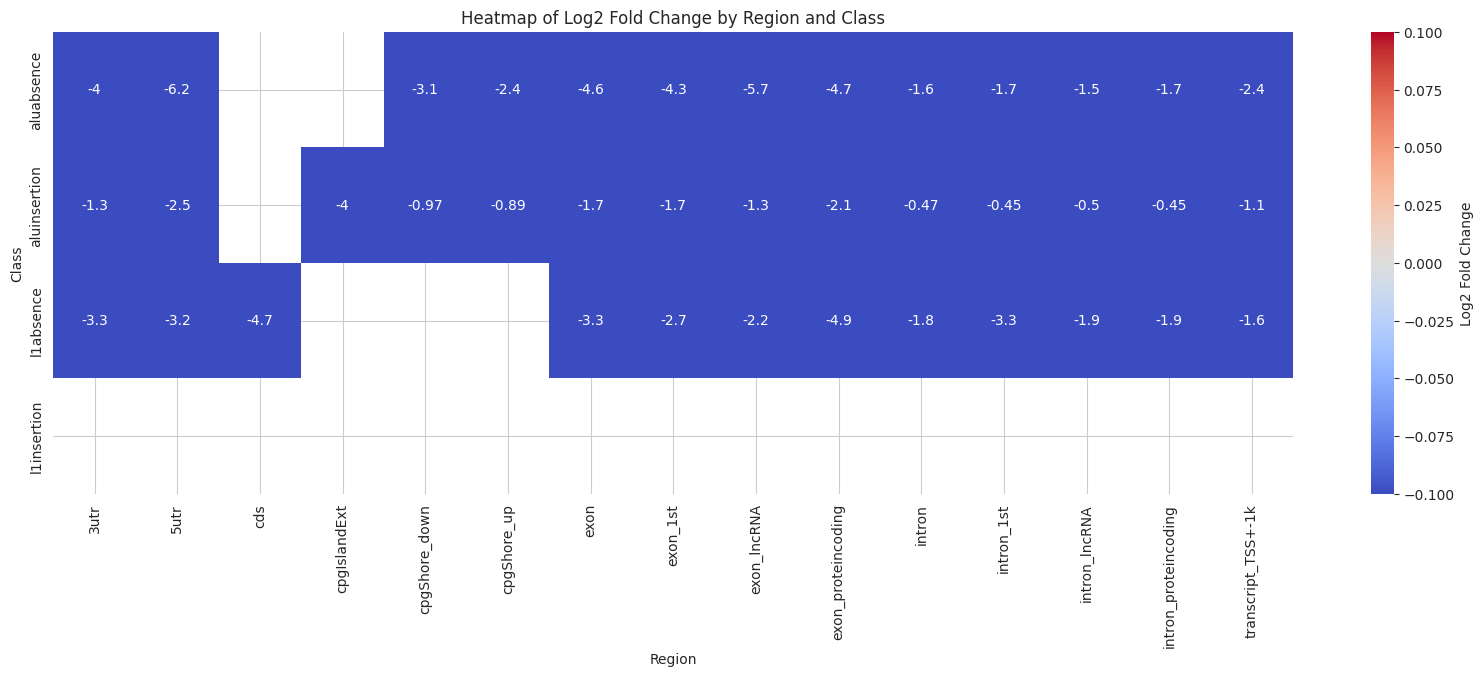

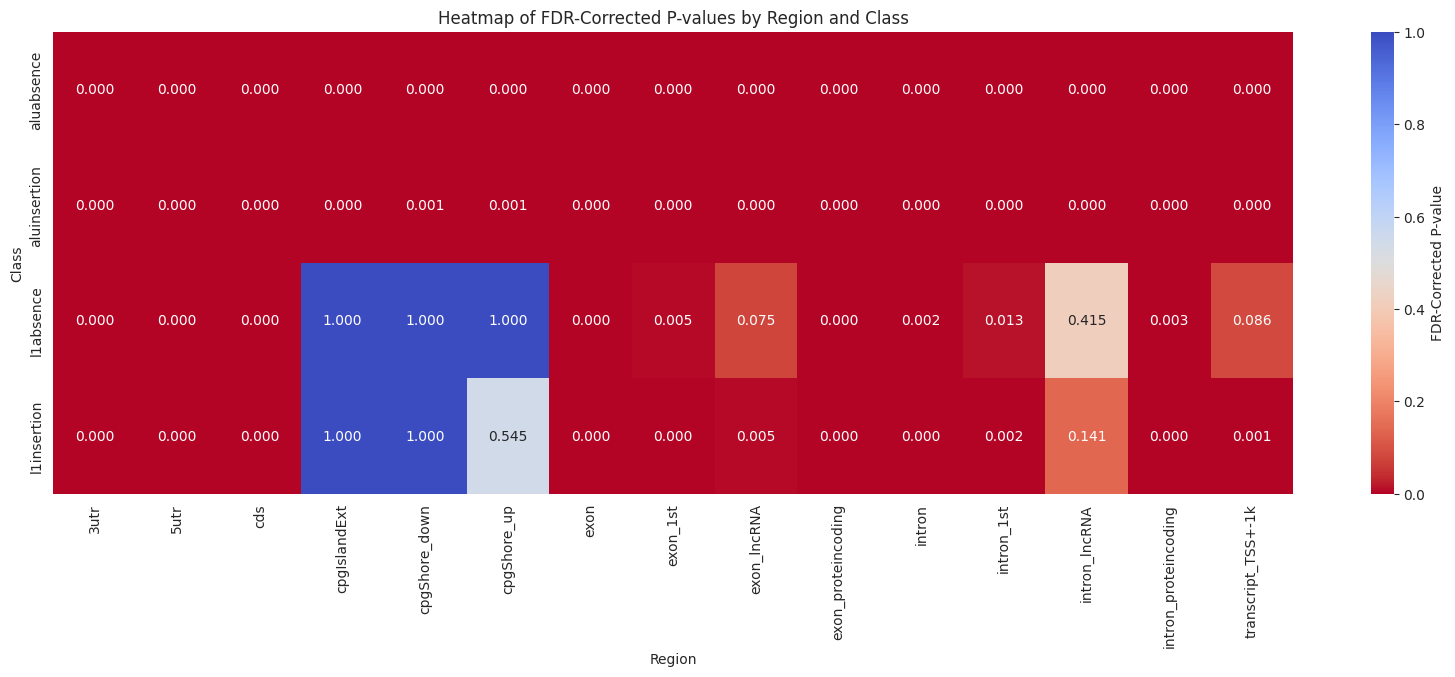

In [446]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
# Plot Fold Change Heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_fc_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Log2 Fold Change'})
plt.title('Heatmap of Log2 Fold Change by Region and Class')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()

# Step 3: Pivot the DataFrame for FDR-Corrected P-Values Heatmap
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Plot FDR-Corrected P-Values Heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(
    heatmap_fdr_data,
    annot=True,
    fmt=".3f",  # Show FDR-corrected p-values with 3 decimal places
    cmap='coolwarm_r',
    cbar_kws={'label': 'FDR-Corrected P-value'}
)
plt.title('Heatmap of FDR-Corrected P-values by Region and Class')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()


In [ ]:
#insertion only
#======================
l1_out = l1_all_df.groupby(3).count()[0]
alu_out = pd.concat([alu_cgi_df.groupby(13).count()[0],alu_all_df.groupby(13).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={3:'region', 0:'count'}, inplace=True)
alu_out.rename(columns={13:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)
        from scipy.stats import fisher_exact
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

In [ ]:
#het only vs hom only
#====================
l1_out = l1_all_df.groupby(3).count()[0]
alu_out = pd.concat([alu_cgi_df.groupby(12).count()[0],alu_all_df.groupby(12).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={3:'region', 0:'count'}, inplace=True)
alu_out.rename(columns={12:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:

        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)

        from scipy.stats import fisher_exact
        
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        
        # print("Contingency Table:")
        # print(contingency_table)
        
        # print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")

        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

In [ ]:
#truncated vs full length
#=========================
l1_out = l1_all_df.groupby(3).count()[0]
alu_out = pd.concat([alu_cgi_df.groupby(12).count()[0],alu_all_df.groupby(12).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={3:'region', 0:'count'}, inplace=True)
alu_out.rename(columns={12:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:

        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)

        from scipy.stats import fisher_exact
        
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        
        # print("Contingency Table:")
        # print(contingency_table)
        
        # print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")

        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

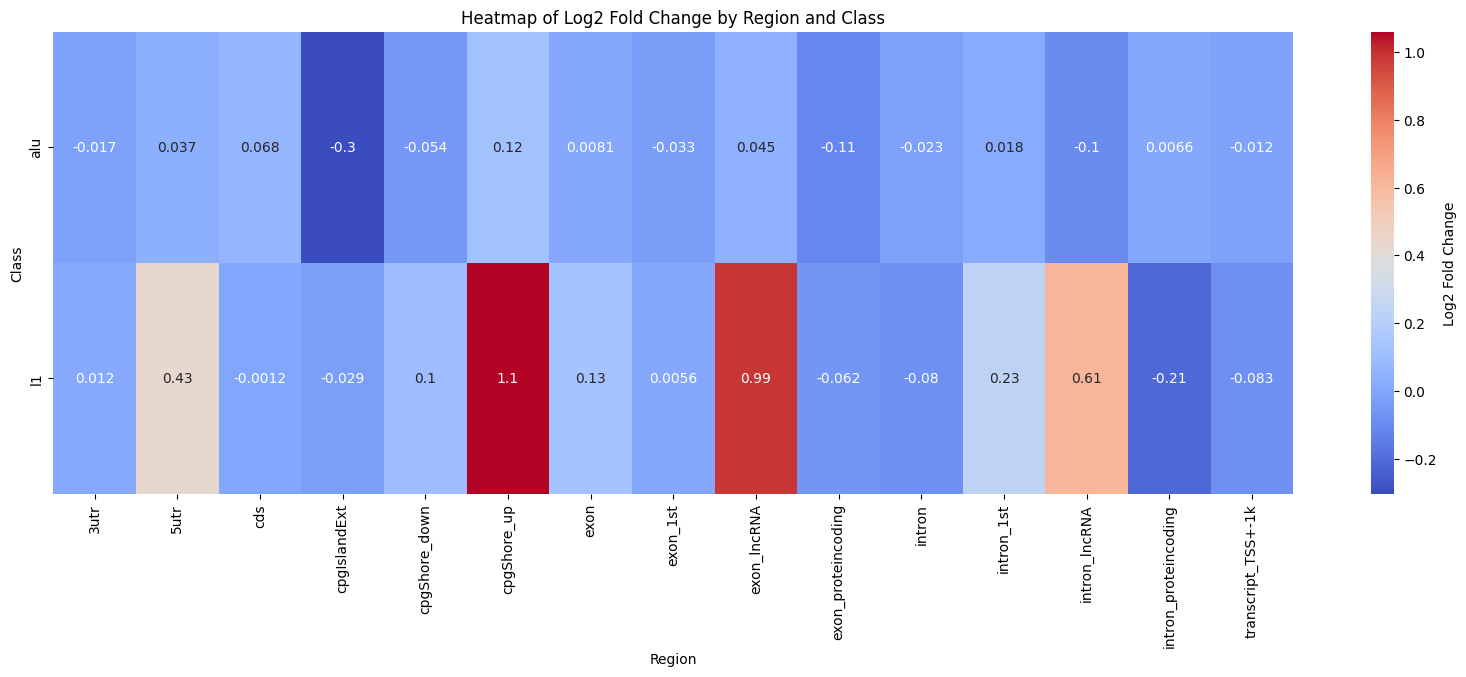

In [351]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a DataFrame
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc
})

# Step 2: Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Log2 Fold Change'})
plt.title('Heatmap of Log2 Fold Change by Region and Class')
plt.ylabel('Class')  # Label for rows
plt.xlabel('Region')  # Label for columns
plt.show()

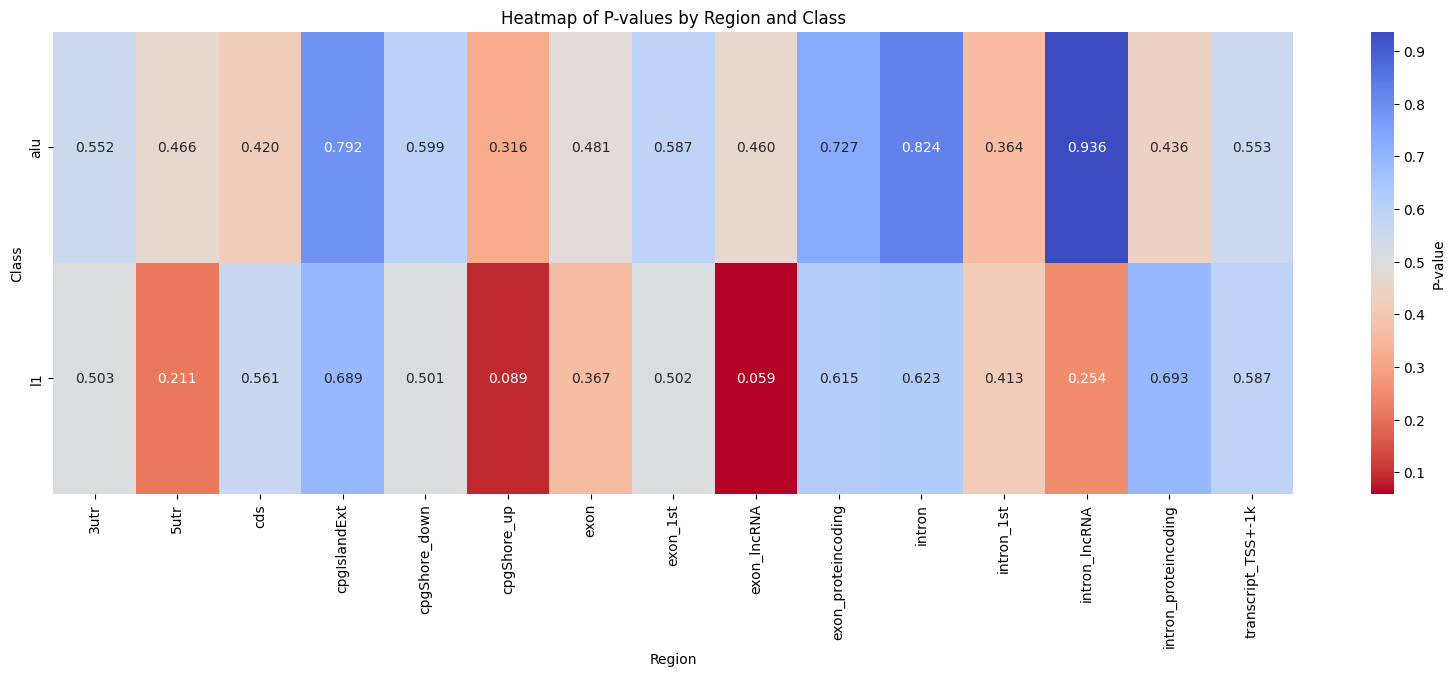

In [352]:
# Step 1: Create a DataFrame
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_pvalue': stat_sig
})

# Step 2: Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = data.pivot(index='stat_class', columns='stat_region', values='stat_pvalue')

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",  # Format to show p-values with 3 decimal places
    cmap='coolwarm_r',  # Reverse the color map to highlight lower p-values
    cbar_kws={'label': 'P-value'}
)
plt.title('Heatmap of P-values by Region and Class')
plt.ylabel('Class')  # Label for rows
plt.xlabel('Region')  # Label for columns
plt.show()
